In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Minimum function
from scipy import optimize

# Used to load Matlab file
from scipy import io

from sklearn.linear_model import LogisticRegression

## Read in Data

#### Dataset

In [2]:
data = io.loadmat('ex3/ex3data1.mat')
print(type(data))

<class 'dict'>


In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [4]:
print(type(data['X']))
print(type(data['y']))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [5]:
# Insert bias unit into X
data['X'] = np.insert(data['X'], 0, 1, axis=1)

# feature matrix & response vector
X = data['X']
y = data['y']

In [6]:
print('X shape(with bias unit) : {}'.format(X.shape))

# y is a classification for each image. 1-10, where "10" is the handwritten "0"
print('y shape : {}; unique elements in y : {}'.format(y.shape, np.unique(y)))

X shape(with bias unit) : (5000, 401)
y shape : (5000, 1); unique elements in y : [ 1  2  3  4  5  6  7  8  9 10]


#### Visualization

In [7]:
def getData2Img(featureMatrix):
    """
    Randomly pick 100 rows from feature matrix, each row is 1*400, and creat image object (20*20)
    """
    sample_row = np.random.choice(featureMatrix.shape[0], 100)
    sample_square = []
    for i in sample_row:
        sample_square.append(featureMatrix[i, 1:].reshape(-1, 20).T)
    return(np.array(sample_square))

In [8]:
def displayImg(featureMatrix):
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(getData2Img(X)[i])
        plt.axis('off');

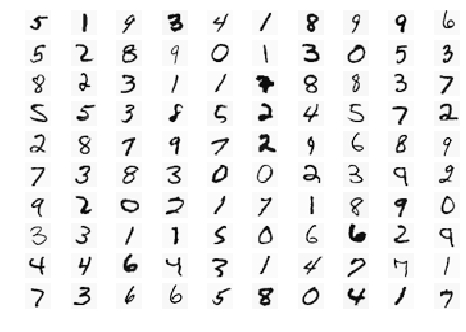

In [9]:
displayImg(X)

## Multiclass Classification

In [16]:
# Some useful variables
m = y.size  # m samples
n = X.shape[1]  # n features(bias unit included)

#### Vectorizing Logistic Regression

In [10]:
# Sigmoid function
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return(g)

# Logistic Hypothesis
def h(theta, X):
    hypothesis = sigmoid(np.dot(X, theta))
    return(hypothesis)

In [17]:
# Regularized Cost Function
def computeCostReg(theta, X, y, lambdaConst):
    reg_term = (lambdaConst/2/m) * np.sum(theta[1:]**2)  # regularized theta, theta_0 is neglected
    J = (-1/m)* (np.dot(y.T, np.log(h(theta, X))) + np.dot((1-y).T, np.log(1-h(theta, X)))) + reg_term
    return (J)

#### One-VS-All Classification

In [45]:
# Use Conjucate Gradient algorithms to find optimization theta
def optimizeThetaReg(theta, X, y, lambdaConst):
    result = optimize.minimize(computeCostReg, x0=theta, args=(X, y.ravel(), lambdaConst),  method='CG', 
                      options={"maxiter":50, "disp":False} )
    return (result.x.reshape(-1,1))  # result.x is optimize theta, shape:(401, 1)

In [81]:
def oneVsAll(theta, num_labels, lambdaConst):
    """
    thata_all is a C*n (C=num_labels; n=401) theta matrix, it will contain all theta values, 
    where each row of theta matrix corresponds to the learned logistic regression parameters for one class.
    """
    #  unique elements in y : [ 1  2  3  4  5  6  7  8  9 10]
    theta_all = []
    for K in range(1, num_labels+1):
        Class = np.ones([y.size, 1])*K
        logic_y = Class==y
        logic_result = optimizeThetaReg(theta_init, X, logic_y, lambdaConst)  # shape:(401, 1)
        theta_all.append(logic_result.T)  # shape:(1, 401)
    return(np.array(theta_all))  # shape:(10, 401)

In [82]:
theta_init = np.zeros([n, 1])
theta = oneVsAll(theta_init, num_labels=10, lambdaConst=0)

In [93]:
theta = theta.reshape(10, 401)

In [94]:
theta

array([[ -3.57243983e+00,   0.00000000e+00,   0.00000000e+00, ...,
          6.84681363e-03,   3.00175397e-07,   0.00000000e+00],
       [ -3.03585851e+00,   0.00000000e+00,   0.00000000e+00, ...,
          6.72307739e-03,  -7.69100878e-04,   0.00000000e+00],
       [ -5.29007143e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -4.01503012e-05,   9.27366385e-07,   0.00000000e+00],
       ..., 
       [ -2.40941598e-01,   0.00000000e+00,   0.00000000e+00, ...,
         -1.20275372e-06,   1.25660836e-07,   0.00000000e+00],
       [ -5.56678020e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -1.01218368e-03,   7.61306284e-05,   0.00000000e+00],
       [ -9.14810208e+00,   0.00000000e+00,   0.00000000e+00, ...,
         -4.59081220e-04,   2.27614809e-05,   0.00000000e+00]])

#### One-VS-All Prediction

In [108]:
def predictOneVsAll(theta, X):
    probability = h(theta.T, X)
    # find the maximum value from each row, classes is 1~10, so python indexing + 1
    return(np.argmax(probability, axis=1)+1)

In [110]:
pred = predictOneVsAll(theta, X)
print('Training set accuracy: {}%'.format(np.mean(pred == y.ravel())*100))

Training set accuracy: 89.7%


#### Multiclass Logistic Regression with scikit-learn

In [117]:
# C=1/lambda; Use L2 regularization; For multiclass problems: only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’
logreg = LogisticRegression(C=1, penalty='l2', solver='newton-cg')  

# sklearn fits intercept automatically, so we "exclude" the bias unit column from X when fitting.
logreg.fit(X[:, 1:], y.ravel())

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [138]:
pred2 = logreg.predict(X[:,1:])
print('Training set accuracy : {}%'.format(np.mean(pred2 == y.ravel())*100))

Training set accuracy : 94.46%


## Neural Networks

#### Model Representation

In [119]:
# Use parameters from a neural network that we have already trained.
# Implement the feedforward propagation algorithm.
weights = io.loadmat('ex3/ex3weights.mat')
print(type(weights))

<class 'dict'>


In [122]:
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [124]:
print(type(weights['Theta1']))
print(type(weights['Theta2']))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [125]:
# network parameters
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

print('Theta1 shape : {}'.format(Theta1.shape))
print('Theta2 shape : {}'.format(Theta2.shape))

Theta1 shape : (25, 401)
Theta2 shape : (10, 26)


#### Feedforward Propagation and Prediction

In [136]:
def predictNN(X, Theta1, Theta2):
    #  a1 is input layer which is feature matrix
    z2 = np.dot(X, Theta1.T)  # hidden layer
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, 1, axis=1)  # add bias unit
    z3 = np.dot(a2, Theta2.T)  # output layer
    a3 = sigmoid(z3)
    return(np.argmax(a3, axis=1)+1)  # find the maximum value from each row, classes is 1~10, so python indexing + 1

In [144]:
predNN = predictNN(X, Theta1, Theta2)
print('Training set accuracy : {}%'.format(np.mean(predNN==y.ravel())*100))

Training set accuracy : 97.52%
